# Internal Flow in a Room

## Introduction

One of the most useful things about AeroSandbox is that it lets you code in a *declarative*, rather than *imperative* style. This means that your code says *what the problem is*, not *how you want it solved*. For engineers who often want to get to results as quickly as possible, this results in more readable, more maintainable, and more reusable code.

An example where this might come up is when you're trying to write a bespoke fluid solver for some specific problem.

## Problem Description

Imagine you're a public health researcher studying the spread of an airborne viral disease in a room. You want a quick model of what the airflow looks like in a room, so you can predict how the virus might spread.



Consider the following room:

In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p
from scipy import interpolate

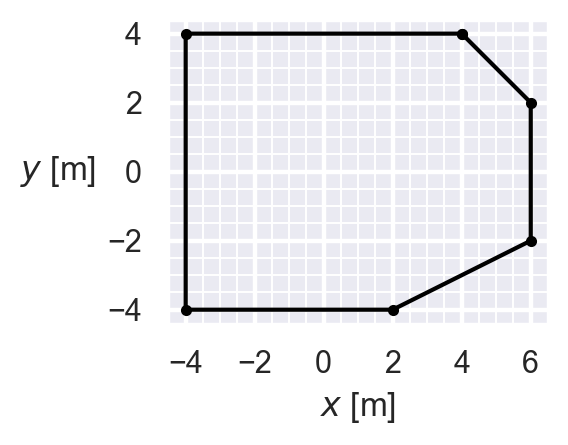

In [2]:
corners = np.array([
    [4, 4],
    [-4, 4],
    [-4, -4],
    [2, -4],
    [6, -2],
    [6, 2],
    [4, 4],
])

fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(*corners.T, ".-k")
p.equal()
p.show_plot(None, "$x$ [m]", "$y$ [m]")

We can "upsample" this a bit for our fluid flow problem:

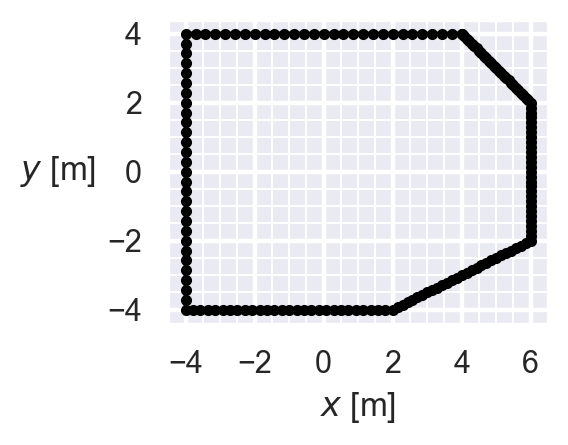

In [3]:
N_per_side = 200 // len(corners)
points = interpolate.interp1d(
    np.linspace(0, 1, len(corners)),
    corners,
    axis=0,
)(np.linspace(0, 1, N_per_side * (len(corners) - 1) + 1))

fig, ax = plt.subplots(figsize=(3, 3))
plt.plot(*points.T, ".-k")
p.equal()
p.show_plot(None, "$x$ [m]", "$y$ [m]")

Now, let's place a vortex of initially-unknown strength at each point, and a "collocation point" (boundary-condition point) halfway between each pair of points:

In [4]:
vortex_points = points[:-1, :]
collocation_points = (points[:-1, :] + points[1:, :]) / 2

The strength of these vortices is initially unknown, so just set them as variables in an `Opti` environment and keep going:

In [5]:
opti = asb.Opti()
strengths = opti.variable(init_guess=np.zeros(len(vortex_points)))

The fan can be modeled as a doublet, which is a source-sink (or, interestingly, equivalently, a vortex-vortex pair). Let's place the doublet at the center of the room, with a known strength:

In [6]:
from potentialflowvisualizer import Flowfield, Doublet, Vortex

fan = Doublet(
    strength=2,
    x=2,
    y=2,
    alpha=np.radians(40),  # Angle of the doublet axis
)

You'll notice that for this, we've imported from the `potentialflowvisualizer` folder, which is located in this same repository. This is a tiny tool I wrote to visualize 2D potential flow fields and define singularity elements. It's not yet part of AeroSandbox, so this is a useful demonstration of using external NumPy-compatible functions with AeroSandbox.

In [7]:
field = Flowfield(objects=[fan] + [
    Vortex(
        strength=strengths[i],
        x=vortex_points[i, 0],
        y=vortex_points[i, 1],
    )
    for i in range(len(vortex_points))
])

Now, let's define the boundary conditions:

In [8]:
V_collocations = np.stack([
    field.get_x_velocity_at(collocation_points),
    field.get_y_velocity_at(collocation_points),
], axis=1)

tangent_vectors = np.roll(collocation_points, 1, axis=0) - np.roll(collocation_points, -1, axis=0)
normal_vectors = np.stack([
    tangent_vectors[:, 1],
    -tangent_vectors[:, 0]
], axis=1)

wall_normal_velocity_at_collocation_points = np.sum(
    V_collocations * normal_vectors,
    axis=1
)

opti.subject_to(np.sum(strengths) == 0)
opti.minimize(np.sum(wall_normal_velocity_at_collocation_points ** 2))

Believe it or not, that's the entire problem setup done - we've set up a custom flow solver for this problem in only around 50 lines of code.

Now we solve:

In [9]:
sol = opti.solve()

field = sol(field)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      168
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    14196

Total number of variables............................:      168
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2076720e-02 0.00e+00 8.32e-02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

We can visualize the results, too:

C:\GitHub\AeroSandbox\tutorial\06 - Aerodynamics\04 - Easily Writing Custom Flow Solvers\potentialflowvisualizer\objects.py:129: RuntimeWarning: invalid value encountered in divide
  return self.strength / (2 * np.pi) * -(points[:, 1] - self.y) / (
C:\GitHub\AeroSandbox\tutorial\06 - Aerodynamics\04 - Easily Writing Custom Flow Solvers\potentialflowvisualizer\objects.py:135: RuntimeWarning: invalid value encountered in divide
  return self.strength / (2 * np.pi) * (points[:, 0] - self.x) / (


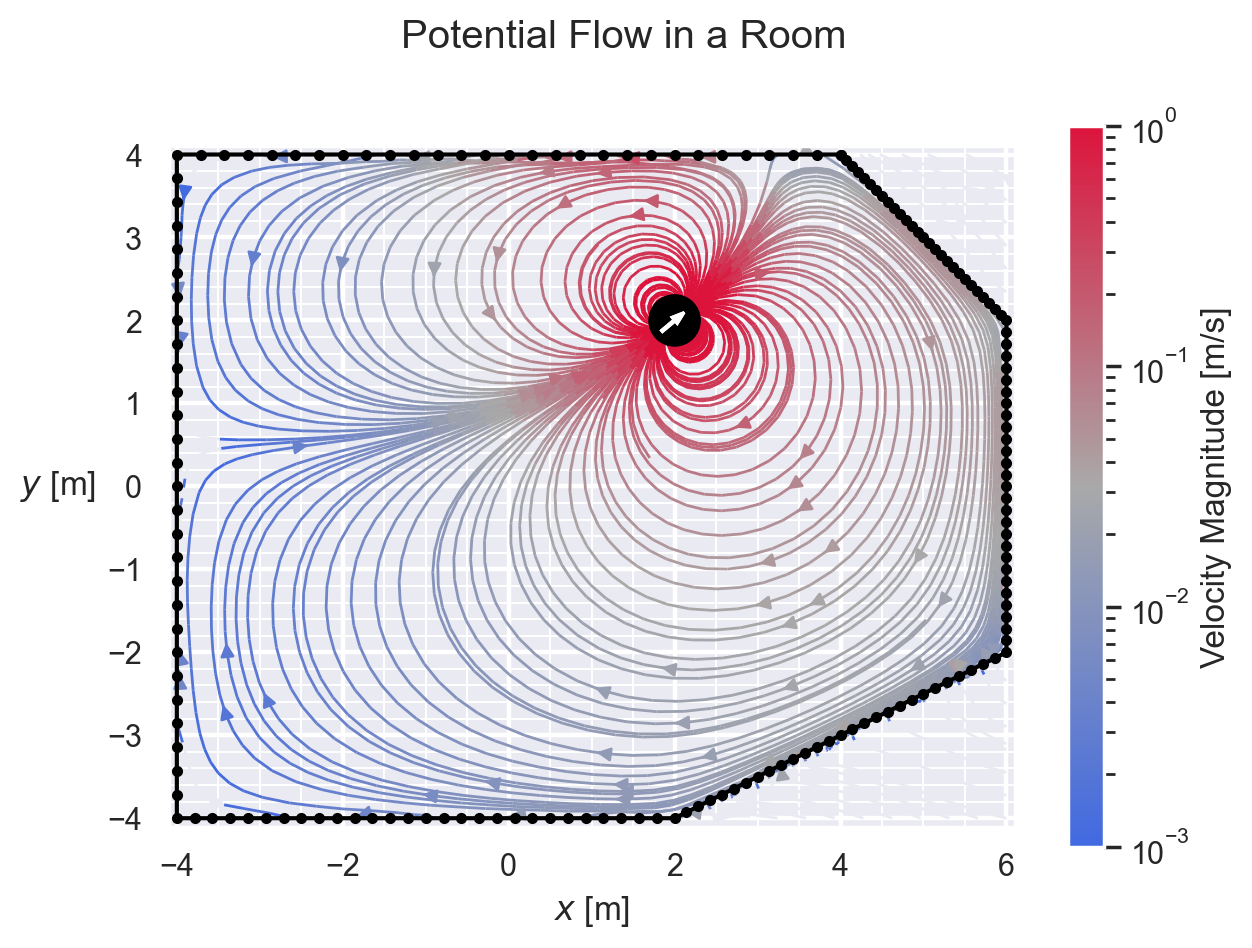

In [10]:
xlim = np.array([points[:, 0].min(), points[:, 0].max()])
ylim = np.array([points[:, 1].min(), points[:, 1].max()])

from matplotlib.colors import LinearSegmentedColormap, LogNorm
from matplotlib import cm

# Extract colors from RdBu and coolwarm colormaps
color_blue = "royalblue"  #"#cm.RdBu(float(0))
color_gray = "darkgray"
color_red = "crimson"  #cm.RdBu(float(1))

# Create custom colormap using LinearSegmentedColormap.from_list
colors = [color_blue, color_gray, color_red]
positions = [1e-1, 1e-2, 1e-3]
cmap = LinearSegmentedColormap.from_list('Custom_Colormap', colors, N=256)
cmap.set_under(ax.get_facecolor())

# Logarithmic normalization
norm = LogNorm(vmin=1e-3, vmax=1)

# from matplotlib.colors import LogNorm

fig, ax = plt.subplots()

field.draw_streamlines(
    x_points=np.linspace(*xlim, 300),
    y_points=np.linspace(*ylim, 300),
    cmap=cmap,
    norm=norm,
    show=False
)

plt.plot(*points.T, ".-k")

ax.add_patch(
    plt.Circle(
        xy=(fan.x, fan.y),
        radius=0.3,
        color="k",
        zorder=4,
    )
)
ax.add_patch(
    plt.arrow(
        x=fan.x - 0.2 * np.cos(fan.alpha),
        y=fan.y - 0.2 * np.sin(fan.alpha),
        dx=0.2 * np.cos(fan.alpha),
        dy=0.2 * np.sin(fan.alpha),
        width=0.02,
        head_width=0.1,
        color="w",
        zorder=5,
    )
)

plt.xlim(xlim + np.array([-0.1, 0.1]))
plt.ylim(ylim + np.array([-0.1, 0.1]))
p.equal()
p.show_plot("Potential Flow in a Room", "$x$ [m]", "$y$ [m]")